In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import xarray as xr
logger = logging.getLogger(__name__)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rcParams.update({'font.size': 18})

[ruth-macbook.local:23828] shmem: mmap: an error occurred while determining whether or not /var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T//ompi.ruth-macbook.503/jf.0/2332164096/sm_segment.ruth-macbook.503.8b020000.0 could be created.


Here the time dependendent IVP problem we're looking to iterate starts from the following
$$ \nabla\cdot\Big(\frac{1}{h}\nabla\frac{\partial \psi}{\partial t}\Big)+f\hat{\mathbf{k}}\cdot \nabla\psi\times\nabla\Big(\frac{1}{h}\Big) = \underbrace{-\frac{\kappa}{h}\nabla\cdot\Big(\frac{1}{h}\nabla\psi\Big)}_{\text{dissipation}}+\underbrace{w_{Ek}\cos(\omega_\text{force} f t)}_{\text{forcing} (F\text{ below})}$$
which is the system considered previously with no assumed form to the temporal dependence (no ansatz) and the inclusion of both dissipation and ekman forcing as some frequency or range of frequencies $\omega_\textrm{force}$.

So we can break this out and try to optimize it. Basically, as much as possible we want to avoid having non-symmetric terms (i.e. $h$) in the LHS of the system since this is what's formulated into a linear operator to be solved at each timestep. 

To do that, we have to implement a couple of tricks. Firstly (not a trick...) everything is expanded out and multiplied by $h$ so we have something to start from without inverse $h$ terms at least.

$$-h(\partial_i h)\partial_i\partial_t\psi + h^2\partial_i^2\partial_t\psi - hf\epsilon_{ijz}\partial_i\psi\partial_jh - \kappa\partial_jh\partial_i\psi + h\kappa\partial_i^2\psi = h^3F$$

Ok now we have to implement an actual trick, and that's to set $h = h_0 + h_1$ where $h_0$ is either a constant or radially symmetric and all the non-symmetric stuff is held within $h_1$, then rearrange everything so that all $h_1$ terms are implicit but we still have some flavor of the time dependence and stiff terms (diffusivity) on the LHS so that the system can function but (hopefully) be way less slow since we don't have asymmetries in the linear operator.

This turns out as (once we convert back to vector form):

$$-h_0\nabla h_0\cdot\nabla\partial_t\psi + h_0^2\nabla^2\partial_t\psi - h_0 f\hat{\mathbf{z}}\cdot(\nabla\psi\times\nabla h_0) - \kappa(\nabla h_0\cdot\nabla\psi) + h_0\kappa\nabla^2\psi$$
$$ = (h\nabla h - h_0\nabla h_0)\cdot\nabla\partial_t\psi - (h^2-h_0^2)\nabla^2 \partial_t\psi + hf\hat{\mathbf{z}}\cdot(\nabla\psi\times\nabla h) - h_0f\hat{\mathbf{z}}\cdot(\nabla\psi\times\nabla h_0) + \kappa\nabla h_1\nabla\psi - h_1\kappa\nabla^2\psi + h^3F$$

Then we have to have one other little trick because now we have put time dependent terms on the RHS and we can't really have that so we introduce another equation

```ψt    = dist.Field(name='ψt', bases=basis)```

```problem = d3.IVP([ψ,ψt tau1, tau2], time=t, namespace=locals())```

```problem.add_equation("dt(ψ)-ψt = 0")```

Then in the problem above replace every `dt(ψ)` with `ψt` and basically those terms lag one timestep..



Finally, we'll need to include the following boundary conditions,
$$\psi(r=R_i)=0$$
$$\textrm{Dirichlet to Neumann at }r = R_o$$
and tau terms (second order).

**note: we're now in a polar coordinates annulus basis**

In [2]:
from dedalus.core.operators import SpectralOperator1D

class ComplexFourierPseudodifferential(SpectralOperator1D):

    input_basis_type = d3.ComplexFourier
    subaxis_dependence = [True]
    subaxis_coupling = [False]

    def __init__(self, operand, coord, out=None):
        super().__init__(operand, out=out)
        # SpectralOperator requirements
        self.coord = coord
        self.input_basis = operand.domain.get_basis(coord)
        self.output_basis = self.input_basis
        self.first_axis = self.dist.get_basis_axis(self.input_basis)
        self.last_axis = self.first_axis
        self.axis = self.first_axis
        # LinearOperator requirements
        self.operand = operand
        # FutureField requirements
        self.domain = operand.domain.substitute_basis(self.input_basis, self.output_basis)
        self.tensorsig = operand.tensorsig
        self.dtype = operand.dtype

    @classmethod
    def _group_matrix(cls, group, input_basis, output_basis):
        # Rescale group (native wavenumber) to get physical wavenumber
        k = group 
        # dx exp(1j*k*x) = 1j * k * exp(1j*k*x)
        return np.array([[cls.k_func(k)]])


class abs_m_cls(ComplexFourierPseudodifferential):

    name = "abs_m"

    @classmethod
    def k_func(cls, k):
        return abs(k)

    def new_operand(self, operand, **kw):
        if operand == 0:
            return 0
        return abs_m_cls(operand,  self.coord, **kw)

class RealFourierPseudodifferential(SpectralOperator1D):

    input_basis_type = d3.RealFourier
    subaxis_dependence = [True]
    subaxis_coupling = [False]

    def __init__(self, operand, coord, out=None):
        super().__init__(operand, out=out)
        # SpectralOperator requirements
        self.coord = coord
        self.input_basis = operand.domain.get_basis(coord)
        self.output_basis = self.input_basis
        self.first_axis = self.dist.get_basis_axis(self.input_basis)
        self.last_axis = self.first_axis
        self.axis = self.first_axis
        # LinearOperator requirements
        self.operand = operand
        # FutureField requirements
        self.domain = operand.domain.substitute_basis(self.input_basis, self.output_basis)
        self.tensorsig = operand.tensorsig
        self.dtype = operand.dtype

    @classmethod
    def _group_matrix(cls, group, input_basis, output_basis):
        # Rescale group (native wavenumber) to get physical wavenumber
        k = group / input_basis.COV.stretch
        return np.array([[cls.k_func(k), 0],[0, cls.k_func(k)]])


class re_abs_m_cls(RealFourierPseudodifferential):

    name = "abs_m"

    @classmethod
    def k_func(cls, k):
        return abs(k)

    def new_operand(self, operand, **kw):
        if operand == 0:
            return 0
        return abs_m_cls(operand,  self.coord, **kw)

## Construct bathymetry

In [3]:
## variable parameters ##
Ri = 0.5
Ro = 17;
Rs = 12;
Nθ = 64;
Nr = 64;
W = np.pi/5; 
#########
frac = 0.5;
#########
steep = 0.2;
ω_force     = -0.27
κ           = 1e-3
ek_mag      = 0.1
Hmin_island = 0.25;
coriolis    = 1 # we nondimensionalize by f
α           = np.log(Hmin_island)/(2*np.log(Ri)); ## = 1
Hmin_ridge = 1-(1-Hmin_island)*frac; 
b = -np.log(Hmin_ridge)/(2*W)
C = np.pi;

In [4]:
## time evolution
timestepper    = d3.RK222
forcing_freq   = ω_force * coriolis
forcing_period = np.abs(1/forcing_freq) * 2 * np.pi
max_timestep   = forcing_period/1000 # timestep = max_timestep in this implementation
stop_sim_time  = int(forcing_period * 1) 

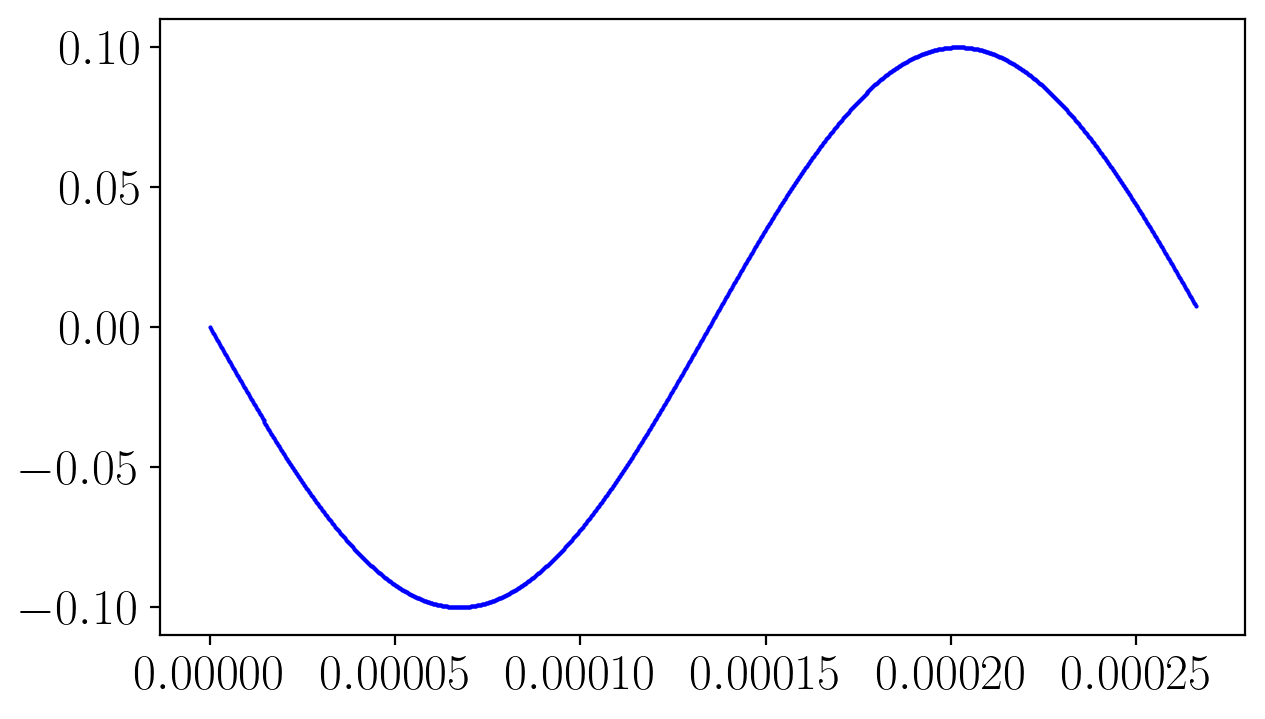

In [5]:
plot_forcing = ek_mag * np.sin(coriolis * ω_force * np.arange(0,stop_sim_time,max_timestep))
fig,(ax) = plt.subplots(1,1, figsize=(7,4))
ax.plot(np.arange(0,stop_sim_time,max_timestep)/(60*60*24),plot_forcing, 'bo', markersize=0.5)
plt.show()

In [6]:
## basis
dtype = np.complex128
coords  = d3.PolarCoordinates('θ', 'r')
dist    = d3.Distributor(coords, dtype=dtype)
basis   = d3.AnnulusBasis(coords, shape = (Nθ, Nr), radii = (Ri,Ro), dealias = 2, dtype = dtype)

In [7]:
## fields
ψ    = dist.Field(name='ψ', bases=basis)
ψt   = dist.Field(name='ψt', bases=basis)
tau1 = dist.Field(name='tau1', bases=basis.outer_edge)
tau2 = dist.Field(name='tau2', bases=basis.outer_edge)
t    = dist.Field(name='t')

In [8]:
## substitutions
θ, r       = dist.local_grids(basis)
lift_basis = basis.derivative_basis(2)
tau_terms  = d3.Lift(tau1, lift_basis, -1) + d3.Lift(tau2, lift_basis, -2)

er = dist.VectorField(coords, bases=basis.radial_basis)
er['g'][1] = 1

R,THETA = np.meshgrid(r,θ)
x = R*np.cos(THETA); y=R*np.sin(THETA)

# bathymetry 
### here h = h0 + h1 where h0 is the symmetric problem of the island
hisland = R**(2*α) 
hisland[hisland>1] = 1
hridge = np.exp(2*b*(np.abs(C-THETA)-W))
hridge[hridge>1] = 1
hridge[R>Rs] = hridge[R>Rs]*np.exp(steep*(R[R>Rs]-Rs))
hridge[hridge>1] = 1
H = np.where(hisland<hridge,hisland,hridge)
h  = dist.Field(name='h',bases=basis )              ;  h['g'] = H
h0 = dist.Field(name='h0',bases=basis.radial_basis ); h0['g'] = hisland[0,:]
# h0 = dist.Field(name='h0',bases=basis ); h0['g'] = hisland
h1 = dist.Field(name='h1',bases=basis )             ; h1['g'] = H - hisland


m_func = lambda m: abs(m)
abs_m = lambda A: abs_m_cls(A, coords['θ']) #note this implements the Dirichlet-to-Neumann BC


## forcing
r0 = 3; θ0 = np.pi/4; σ = 0.3;
gaussian = np.exp(-(x-r0*np.cos(θ0))**2/(2*σ**2) - (y-r0*np.sin(θ0))**2/(2*σ**2));

wek_spatial      = dist.Field(bases=basis)
wek_spatial['g'] = ek_mag * gaussian 
wek              = wek_spatial * np.cos(ω_force * coriolis * t)


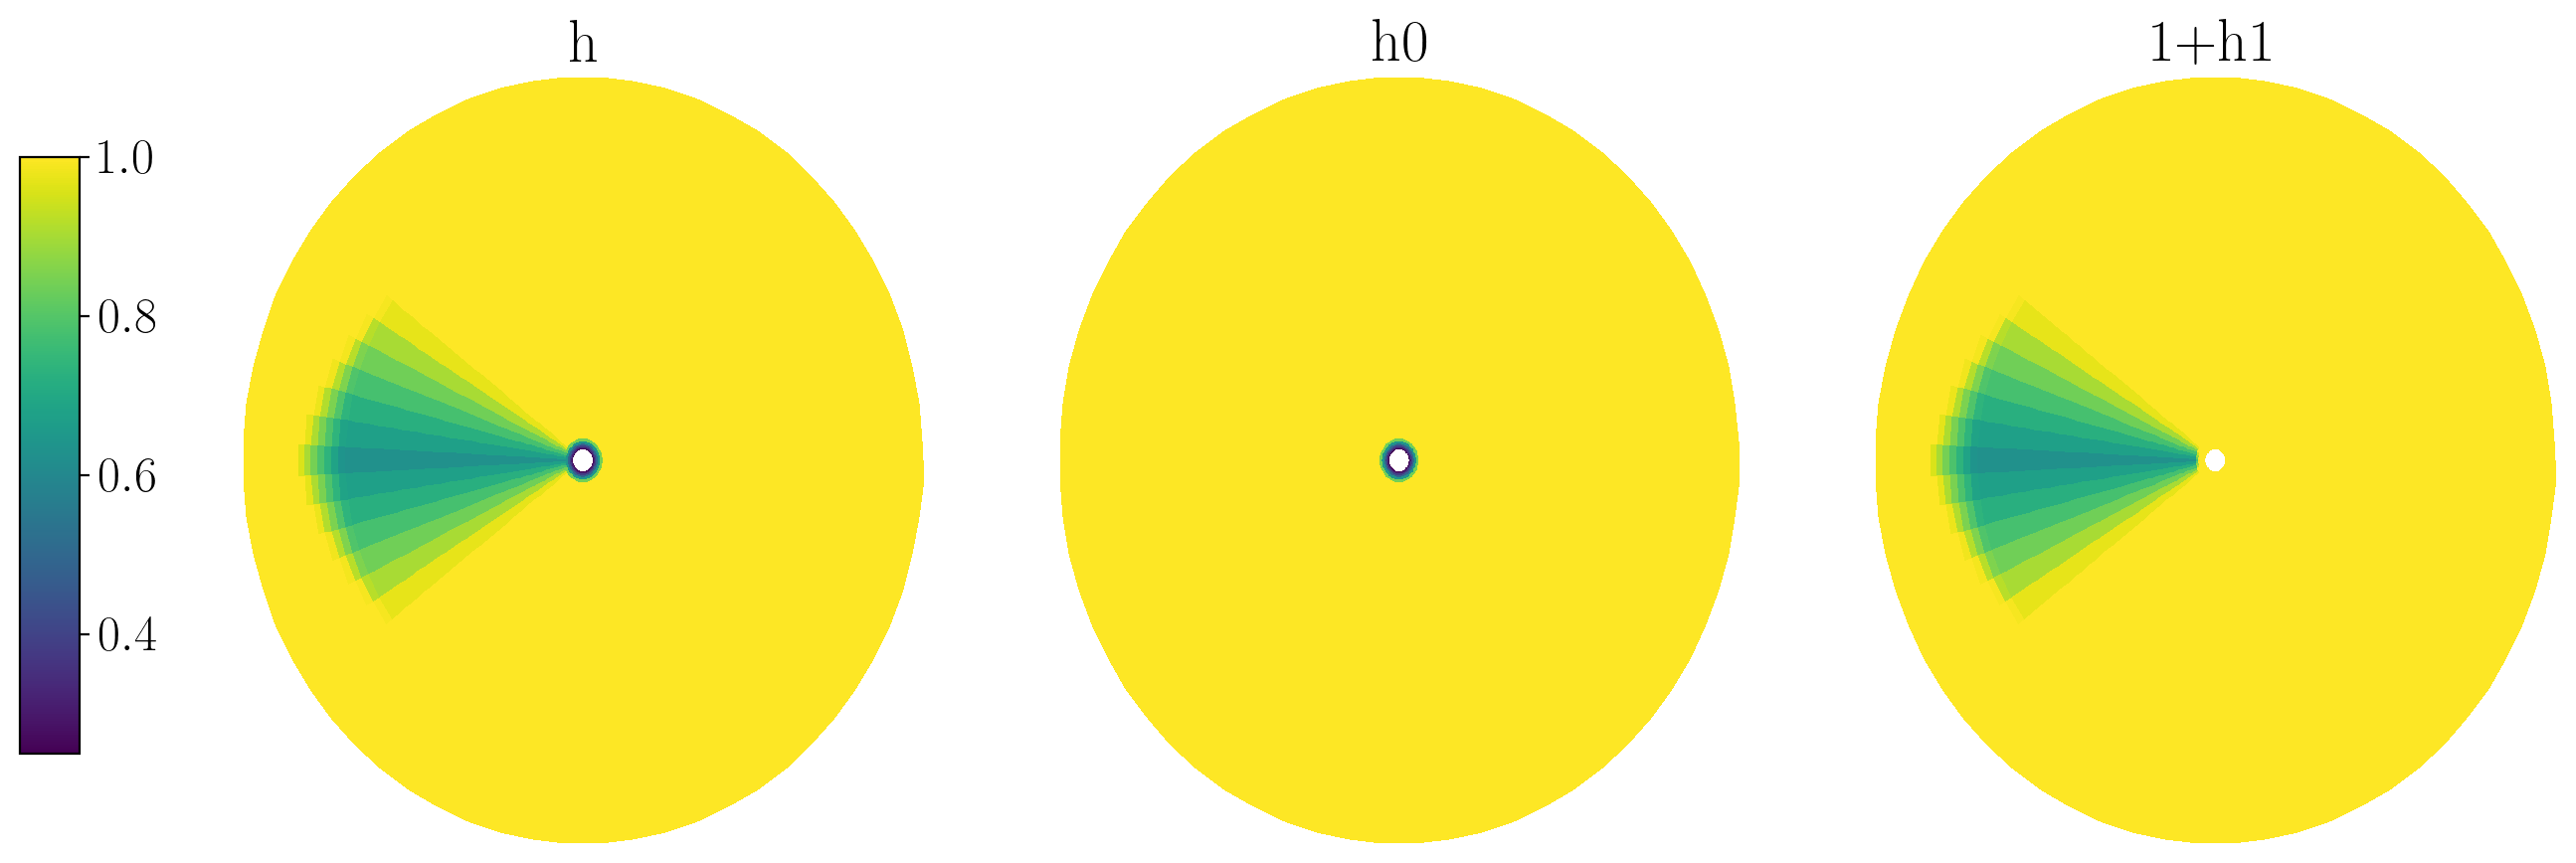

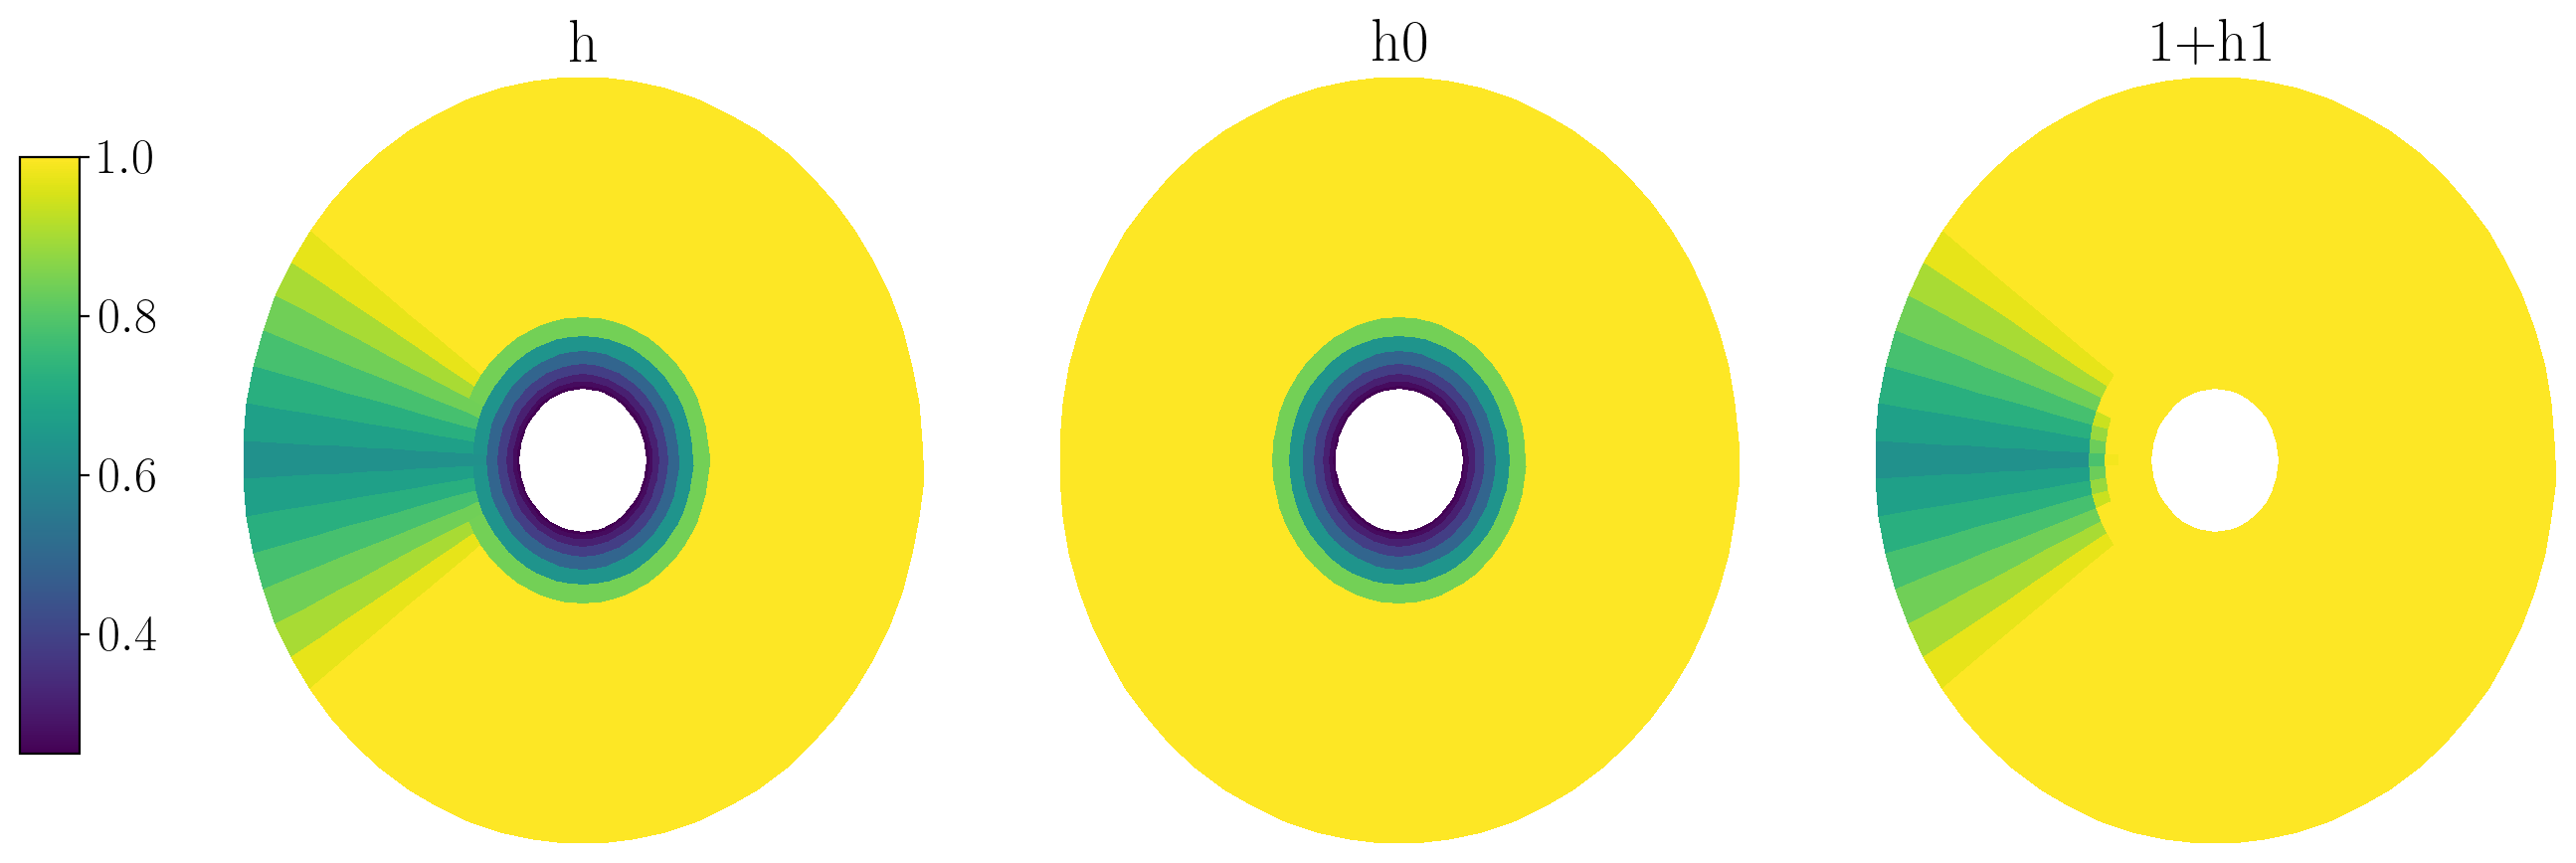

In [9]:
fig,(ax,ax1, ax2) = plt.subplots(1,3, figsize=(15,5))
c=ax.pcolormesh(x,y,h['g'].real, vmin=0.25, vmax=1)
ax1.pcolormesh(x,y,(R*0+1)*h0['g'].real, vmin=0.25, vmax=1)
ax2.pcolormesh(x,y,1+h1['g'].real, vmin=0.25, vmax=1)
cax = fig.add_axes([0.05, 0.2, 0.02, 0.6])
cbar=plt.colorbar(c,cax = cax,orientation='vertical',shrink = 0.5)
ax.axis('off'); ax1.axis('off'); ax2.axis('off')
ax.set_title('h');ax1.set_title('h0');ax2.set_title('1+h1')
plt.show()

i = 15
fig,(ax,ax1, ax2) = plt.subplots(1,3, figsize=(15,5))
c=ax.pcolormesh(x[:,:i],y[:,:i],h['g'].real[:,:i], vmin=0.25, vmax=1)
ax1.pcolormesh(x[:,:i],y[:,:i],((R*0+1)*h0['g'].real)[:,:i], vmin=0.25, vmax=1)
ax2.pcolormesh(x[:,:i],y[:,:i],1+h1['g'].real[:,:i], vmin=0.25, vmax=1)
cax = fig.add_axes([0.05, 0.2, 0.02, 0.6])
cbar=plt.colorbar(c,cax = cax,orientation='vertical',shrink = 0.5)
ax.axis('off'); ax1.axis('off'); ax2.axis('off')
ax.set_title('h');ax1.set_title('h0');ax2.set_title('1+h1')
plt.show()

In [10]:
## problem
problem = d3.IVP([ψ,ψt, tau1, tau2], time=t, namespace=locals())
# problem.add_equation("h0*grad(h0)@grad(dt(ψ)) + h0**2*lap(dt(ψ)) - h0*coriolis*(skew(grad(ψ))@grad(h0)) - κ*(grad(h0)@grad(ψ)) + h0*κ*lap(ψ) \
#                       = (h*grad(h) - h0*grad(h0))@grad(ψt) - (h**2-h0**2)*lap(ψt) + h*coriolis*(skew(grad(ψ))@grad(h)) - \
#                       h0*coriolis*(skew(grad(ψ))@grad(h0)) + κ*(grad(h1)@grad(ψ)) - h1*κ*lap(ψ) + h**3*wek")

problem.add_equation("h0*grad(h0)@grad(dt(ψ)) + h0**2*lap(dt(ψ)) - h0*coriolis*(skew(grad(ψ))@grad(h0)) - κ*(grad(h0)@grad(ψ)) + h0*κ*lap(ψ) \
                      = (h*grad(h) - h0*grad(h0))@grad(ψt) - (h**2-h0**2)*lap(ψt) + h*coriolis*(skew(grad(ψ))@grad(h)) - \
                      h0*coriolis*(skew(grad(ψ))@grad(h0)) + κ*(grad(h1)@grad(ψ)) - h1*κ*lap(ψ) + h**3*wek")


problem.add_equation("dt(ψ)-ψt = 0") #timestepping lag for non-symmetric components
problem.add_equation("ψ(r=Ri)=0") #inner BC 
# problem.add_equation("ψ(r=Ro)=0") #inner BC 
problem.add_equation("(er@grad(ψ))(r=Ro) + abs_m(ψ(r=Ro)) / Ro = 0") #outer BC (dirichlet neumann)


{'LHS': Add(interp(Dot(<Field 5202861696>, Grad(<Field 5270184848>)), r=17), Mul(0.058823529411764705, abs_m(interp(<Field 5270184848>, r=17)))),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('complex128'),
 'M': 0,
 'L': Add(interp(Dot(<Field 5202861696>, Grad(<Field 5270184848>)), r=17), Mul(0.058823529411764705, abs_m(interp(<Field 5270184848>, r=17)))),
 'F': <Field 5272534720>,
 'domain': <dedalus.core.domain.Domain at 0x13a20a9c0>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False,  True])}

In [11]:
## solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2024-08-05 11:43:27,050 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 1s, Remaining: 37s, Rate: 1.7e+00/s
2024-08-05 11:43:29,887 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 3s, Remaining: 28s, Rate: 2.0e+00/s
2024-08-05 11:43:33,128 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 7s, Remaining: 24s, Rate: 2.1e+00/s
2024-08-05 11:43:36,368 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 10s, Remaining: 20s, Rate: 2.1e+00/s
2024-08-05 11:43:36,836 subsystems 0/1 INFO :: Building subproblem matrices 22/64 (~34%) Elapsed: 10s, Remaining: 20s, Rate: 2.1e+00/s
2024-08-05 11:43:39,648 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 13s, Remaining: 17s, Rate: 2.1e+00/s
2024-08-05 11:43:42,901 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 16s, Remaining: 14s, Rate: 2.1e+00/s
2024-08-05 11:43:46,171 subsystems 0/1 INFO :: Building subpr

In [12]:
# Analysis
snapshots = solver.evaluator.add_file_handler('full_snapshots', sim_dt=1)
snapshots.add_task(ψ, name='streamfunction')

In [13]:
%%time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = max_timestep
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2024-08-05 11:44:03,459 __main__ 0/1 INFO :: Starting main loop
2024-08-05 11:44:03,795 __main__ 0/1 ERROR :: Exception raised, triggering end of main loop.
2024-08-05 11:44:03,795 solvers 0/1 INFO :: Final iteration: 0
2024-08-05 11:44:03,796 solvers 0/1 INFO :: Final sim time: 0.0
2024-08-05 11:44:03,796 solvers 0/1 INFO :: Setup time (init - iter 0): 37.07 sec
2024-08-05 11:44:03,796 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.


RuntimeError: failed to factorize matrix at line 434 in file ../scipy/sparse/linalg/_dsolve/SuperLU/SRC/zpanel_bmod.c


In [ ]:
import matplotlib
from matplotlib import animation
from IPython.display import HTML
import h5py

# Plot parameters
task = 'streamfunction'
cmap = plt.cm.RdBu_r
dpi = 100
figsize = (6, 6)

# Create figure
with h5py.File('dirichletneumann_snapshots/dirichletneumann_snapshots_s1.h5', mode='r') as file:
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])
    # Plot writes
    dset = file['tasks'][task]
    theta = dset.dims[1][0][:]
    r = dset.dims[2][0][:]
    R,THETA = np.meshgrid(r,theta)
    x = R*np.cos(THETA); y=R*np.sin(THETA)
    data = np.real(dset[0])
    # clim = 0.04
    clim = np.max(np.abs(dset[:]))
    norm = matplotlib.colors.Normalize(-clim, clim)
    fc = cmap(norm(data))
    surf = ax.pcolormesh(x, y, data, cmap = cmap,clim = (-clim,clim))
    # ax.axis('off')

    def animate(i):
        data = dset[i]
        surf.set_array(np.real(data).ravel())
        return [surf]
    
    anim = animation.FuncAnimation(fig, animate, frames=dset.shape[0], interval=50, blit=True)
    video = HTML(anim.to_html5_video())
    plt.close(fig)

video.data = video.data.replace('autoplay', '')
video